In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import openai

from dotenv import load_dotenv

load_dotenv()

openai.api_key = os.getenv('OPENAI_KEY')

# Load data

In [175]:
from utils.constants import STAGE_DIR

# with open(STAGE_DIR / 'previous-work' / 'EVAL_DATA.txt') as f:
#     eval_sentences = f.read()

with open(STAGE_DIR / 'previous-work' / 'TRAINING_HOHFELD.txt') as f:
    train_sentences = f.read()

with open(STAGE_DIR / 'previous-work' / 'TRAINING_NO_RELS.txt') as f:
    train_no_sentences = f.read()

In [723]:
all_sentences = train_sentences + '\n\n' + train_no_sentences

In [724]:
from utils.functions import get_dict_from_data

all_sentences_data = get_dict_from_data(all_sentences)

In [188]:
from utils.functions import example_validation_split

examples_data, validation_data = example_validation_split(all_sentences_data, 1, 'relationType')

In [192]:
len(examples_data), len(validation_data)

(5, 141)

# First experiment

In [3]:
from utils.constants import STAGE_DIR

with open(STAGE_DIR / 'previous-work' / 'TRAINING_HOHFELD.txt') as f:
    sentences = f.read()

In [4]:
from utils.functions import get_dict_from_data

evaluation_data = get_dict_from_data(sentences)

In [5]:
# sentences = "\n\n".join(sentence_data['text'] for sentence_data in evaluation_data)

In [12]:
sentences = '''
Las sustituciones, revocaciones, dimisiones y extinciones de mandatose comunicarán a la oficina pública dependiente de la autoridad laboral y al empresario, publicándose asimismo en el tablón de anuncios
'''

In [13]:
prompt = f'''
Given a large set of sentences in spanish from the legal domain, written between triple backticks, your objective is to develop a spanish event extraction task. The steps to achieve it are the following:
1. Identify each sentence in the corpus separated for new lines.
2. In each sentence detect a subject entity, an object entity and an event trigger, usually in the form of a verb. It can happen that a sentence relates more than one object entity with the same subject and event trigger. The sentences can contain entities and phrases that don't correspond to any classification. Also, the object can be separated from the subject and event trigger by these complements. The definitions of each category are the following:
    * event trigger: It refers to the action that is enforced by the legal text. It can be in a negative form.
    * subject entity: It refers to the entity that performs the action of the event trigger.
    * object entity: It refers to the entity that is the receptor of the action. In the legal domain, it can be, for example, a right, a beneficiary from the action, an institution, a non-right, etc.
3. The output of the task should be a list of dictionaries, each dictionary contains the following keys:
    - sentence: the sentence
    - subject: the subject entity
    - object: the object entity
    - event: the event trigger
Note that it can be repeated sentences because of the different subject-event-object combinations.

The set of sentences in spanish to use is the following:

```
{sentences}
```
'''

In [14]:
from utils.functions import get_completion

response = get_completion(prompt)

In [15]:
print(response)

[
    {
        "sentence": "Las sustituciones, revocaciones, dimisiones y extinciones de mandatose comunicarán a la oficina pública dependiente de la autoridad laboral y al empresario, publicándose asimismo en el tablón de anuncios",
        "subject": "Las sustituciones, revocaciones, dimisiones y extinciones de mandatose",
        "object": "a la oficina pública dependiente de la autoridad laboral y al empresario",
        "event": "comunicarán"
    },
    {
        "sentence": "Las sustituciones, revocaciones, dimisiones y extinciones de mandatose comunicarán a la oficina pública dependiente de la autoridad laboral y al empresario, publicándose asimismo en el tablón de anuncios",
        "subject": "Las sustituciones, revocaciones, dimisiones y extinciones de mandatose",
        "object": "en el tablón de anuncios",
        "event": "publicándose"
    }
]


In [72]:
import json

evaluation_predict = json.loads(response)

In [77]:
from utils.metrics import match_score

match_score(evaluation_data, evaluation_predict, 'exact', ['subject', 'object', 'event'])

,Subject,Object,Event,Total
COR,4.000000,0.0,4.000000,8.000000
INC,8.000000,9.0,9.000000,26.000000
PAR,0.000000,0.0,0.000000,0.000000
MIS,0.000000,0.0,0.000000,0.000000
SPU,0.000000,0.0,0.000000,0.000000
Precision,0.333333,0.0,0.307692,0.235294
Recall,0.333333,0.0,0.307692,0.235294
F1 Score,0.333333,0.0,0.307692,0.235294


In [78]:
match_score(evaluation_data, evaluation_predict, 'partial', ['subject', 'object', 'event'])

,Subject,Object,Event,Total
COR,4.000000,0.0,4.000000,8.000000
INC,8.000000,9.0,7.000000,24.000000
PAR,0.000000,0.0,2.000000,2.000000
MIS,0.000000,0.0,0.000000,0.000000
SPU,0.000000,0.0,0.000000,0.000000
Precision,0.333333,0.0,0.384615,0.264706
Recall,0.333333,0.0,0.384615,0.264706
F1 Score,0.333333,0.0,0.384615,0.264706


In [ ]:
from utils.metrics import compute_average_similarity_score

print(f'''
Subject - {compute_average_similarity_score(evaluation_data, evaluation_predict, 'subject')}
Object - {compute_average_similarity_score(evaluation_data, evaluation_predict, 'object')}
Trigger - {compute_average_similarity_score(evaluation_data, evaluation_predict, 'event')}
''')



Subject - 0.4230807787106761
Object - 0.14261991702024798
Trigger - 0.6474204001127077



# Experiments with `PlanTL-GOB-ES/RoBERTalex`

In [ ]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, FillMaskPipeline
from pprint import pprint
tokenizer_hf = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/RoBERTalex')
model = AutoModelForMaskedLM.from_pretrained('PlanTL-GOB-ES/RoBERTalex')
model.eval()
pipeline = FillMaskPipeline(model, tokenizer_hf)
text = f"¡Hola <mask>!"
res_hf = pipeline(text)
pprint([r['token_str'] for r in res_hf])

In [ ]:
tokenizer_hf = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/RoBERTalex')
model = AutoModelForMaskedLM.from_pretrained('PlanTL-GOB-ES/RoBERTalex')
model.eval()
pipeline = FillMaskPipeline(model, tokenizer_hf)
text = f"El contrato de trabajo se podrá <mask>"
res_hf = pipeline(text)

pprint([r['token_str'] for r in res_hf])

In [ ]:
print(res_hf)

In [ ]:
seed = f"El contrato de trabajo se podrá <mask>"
i = 10
while i:
    tokenizer_hf = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/RoBERTalex')
    model = AutoModelForMaskedLM.from_pretrained('PlanTL-GOB-ES/RoBERTalex')
    model.eval()
    pipeline = FillMaskPipeline(model, tokenizer_hf)
    res_hf = pipeline(seed)
    max_score_sequence = max(res_hf, key=lambda x: x['score'])['sequence']
    seed = max_score_sequence + ' <mask>'
    i -= 1

print(seed)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, set_seed
tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/gpt2-large-bne")
model = AutoModelForCausalLM.from_pretrained("PlanTL-GOB-ES/gpt2-large-bne")
generator = pipeline('text-generation', tokenizer=tokenizer, model=model)
set_seed(42)
generator("Los  ", num_return_sequences=5)

# Zero-shot experiment

In [351]:
zero_eval_k = 15

zero_sentences_2 = [
    "\n\n".join(
        sentence_data['text'] \
        for sentence_data in all_sentences_data[i:i+zero_eval_k]) \
        for i in range(0, len(all_sentences_data), zero_eval_k)
]

## Prompt \# 1: Joint Subject and Object Classification

In [194]:
prompt = f'''
We are interested in extracting event information from spanish legal text. Given a large set of sentences in spanish from the legal domain, written between triple backticks, your objective is to extract the roles from the text written in Spanish following the next steps:
1. Identify each sentence in the corpus separated for new lines.
2. In each sentence detect a subject entity, an object entity and an event trigger following the next definitions.
    * subject: Agent of the action, who performs the action.
    * event trigger: Action
    * object: Receiver of the action. There can be more than one object in the sentence.
    * complement: Item which is handled in the relation. There can be more than one complement in the sentence.
3. Classify each subject and object in one of the following labels:
    * LegalAgent: Natural person
    * LegalEntity: Not natural person nor individual. Normally a corporation or an enterprise
    * LegalConcept: Not natural person nor corporation.
4. Classify the relation in one of the following classes:
    * Right
    * Duty
    * NoRight
    * Priviledge
    * Norelation
Right and No-Right are opposites and Duty and Priviledge are opposite as well. Norelation represents a sentence that does not contains a relation.
5. The output of the task should be a list of dictionaries, each dictionary contains the following keys:
    * sentence: the sentence
    * subject: the subject entity
    * complement: the list of complement entities
    * object: the list of object entities
    * event: the event trigger
    * subjectLabel: the classification of the subject entity in step 3
    * objectLabel: the classification of the object entity in step 3
    * relationType: the classification of the relation in step 4

The set of sentences in spanish to use is the following:

```
{sentences}
```
'''

In [195]:
from utils.functions import get_completion

response = get_completion(prompt)

InvalidRequestError: This model's maximum context length is 4097 tokens. However, your messages resulted in 8812 tokens. Please reduce the length of the messages.

In [96]:
print(response)

[
    {
        "sentence": "Los trabajos realizados a título de amistad, benevolencia o buena vecindad.",
        "subject": "trabajos",
        "complement": [],
        "object": [],
        "event": "realizados",
        "subjectLabel": "LegalConcept",
        "objectLabel": "Norelation",
        "relationType": "Norelation"
    },
    {
        "sentence": "Las situaciones de incapacidad temporal, nacimiento, adopción, guarda con fines de adopción, acogimiento, riesgo durante el embarazo, riesgo durante la lactancia y violencia de género interrumpirán el cómputo de la duración del contrato.",
        "subject": "situaciones",
        "complement": [],
        "object": ["cómputo de la duración del contrato"],
        "event": "interrumpirán",
        "subjectLabel": "LegalConcept",
        "objectLabel": "LegalConcept",
        "relationType": "NoRight"
    },
    {
        "sentence": "Si el trabajador tuviera asignadas condiciones o retribuciones especiales en virtud de contrapr

In [97]:
import json

evaluation_predict = json.loads(response)

In [107]:
count = sum(p['objectLabel'] not in ('LegalAgent', 'LegalConcept', 'LegalEntity') and p['objectLabel'] is not None for p in evaluation_predict)
print(count / len(evaluation_predict) * 100)

46.15384615384615


In [113]:
[f['objectLabel'] for f in filter(lambda p: p['objectLabel'] not in ('LegalAgent', 'LegalConcept', 'LegalEntity') and p['objectLabel'] is not None and not p['object'], evaluation_predict)]

['Norelation',
 'Norelation',
 'Norelation',
 'Norelation',
 'Norelation',
 'Norelation']

In [99]:
from utils.metrics import match_score

match_score(evaluation_data, evaluation_predict, 'exact')

,Subject,Object,Event,Complement,Total
COR,4.000000,0.0,4.000000,0.0,8.000000
INC,8.000000,4.0,9.000000,5.0,26.000000
PAR,0.000000,0.0,0.000000,0.0,0.000000
MIS,0.000000,0.0,0.000000,0.0,0.000000
SPU,0.000000,0.0,0.000000,0.0,0.000000
Precision,0.333333,0.0,0.307692,0.0,0.235294
Recall,0.333333,0.0,0.307692,0.0,0.235294
F1 Score,0.333333,0.0,0.307692,0.0,0.235294


In [100]:
match_score(evaluation_data, evaluation_predict, 'partial')

,Subject,Object,Event,Complement,Total
COR,4.000000,0.0,4.000000,0.0,8.000000
INC,8.000000,4.0,7.000000,5.0,24.000000
PAR,0.000000,0.0,2.000000,0.0,2.000000
MIS,0.000000,0.0,0.000000,0.0,0.000000
SPU,0.000000,0.0,0.000000,0.0,0.000000
Precision,0.333333,0.0,0.384615,0.0,0.264706
Recall,0.333333,0.0,0.384615,0.0,0.264706
F1 Score,0.333333,0.0,0.384615,0.0,0.264706


In [101]:
match_score(evaluation_data, evaluation_predict, 'strict')

,Subject,Object,Event,Complement,Total
COR,4.000000,0.0,2.000000,0.0,6.000000
INC,8.000000,4.0,11.000000,5.0,28.000000
PAR,0.000000,0.0,0.000000,0.0,0.000000
MIS,0.000000,0.0,0.000000,0.0,0.000000
SPU,0.000000,0.0,0.000000,0.0,0.000000
Precision,0.333333,0.0,0.153846,0.0,0.176471
Recall,0.333333,0.0,0.153846,0.0,0.176471
F1 Score,0.333333,0.0,0.153846,0.0,0.176471


In [102]:
match_score(evaluation_data, evaluation_predict, 'type')

,Subject,Object,Event,Complement,Total
COR,4.000000,0.0,2.000000,0.0,6.000000
INC,8.000000,4.0,11.000000,5.0,28.000000
PAR,0.000000,0.0,0.000000,0.0,0.000000
MIS,0.000000,0.0,0.000000,0.0,0.000000
SPU,0.000000,0.0,0.000000,0.0,0.000000
Precision,0.333333,0.0,0.153846,0.0,0.176471
Recall,0.333333,0.0,0.153846,0.0,0.176471
F1 Score,0.333333,0.0,0.153846,0.0,0.176471


## Prompt \# 2: Separated Subject and Object Classification

In [352]:
zero_system_2 = '''
We are interested in extracting event information from spanish legal text. Given a large set of sentences in spanish from the legal domain, written between triple backticks, your objective is to extract the roles from the text written in Spanish following the next steps:
1. Identify each sentence in the corpus separated for new lines.
2. In each sentence detect a subject entity, an object entity and an event trigger following the next definitions.
    * subject: Agent of the action, who performs the action.
    * event trigger: Action
    * object: Receiver of the action. There can be more than one object in the sentence.
    * complement: Item which is handled in the relation. There can be more than one complement in the sentence.
3. Classify each subject in one of the following labels:
    * LegalAgent: Natural person
    * LegalEntity: Not natural person nor individual. Normally a corporation or an enterprise
    * LegalConcept: Not natural person nor corporation.
4. Classify each object entity in one of the labels of previous step. If no object is present in the sentence, just leave it as null.
5. Classify the relation in one of the following classes:
    * Right
    * Duty
    * NoRight
    * Priviledge
    * Norelation
Right and No-Right are opposites and Duty and Priviledge are opposite as well. Norelation represents a sentence that does not contains a relation.
6. The output of the task should be a list of dictionaries, each dictionary contains the following keys:
    * sentence: the sentence
    * subject: the subject entity
    * object: the list of object entities or empty list
    * complement: the list of complement entities or empty list
    * event: the event trigger
    * subjectLabel: the classification of the subject entity in step 3
    * objectLabel: the classification of the object entity in step 4. All objects entities have the same classification
    * relationType: the classification of the relation in step 5
'''

zero_prompts_2 = [f'''
The set of sentences in spanish to use is the following:

```
{s}
```
''' for s in zero_sentences_2]

In [353]:
from utils.functions import get_completion

zero_responses_2 = []
for prompt in zero_prompts_2:
    zero_response_2 = get_completion(zero_system_2 + '\n' + prompt)
    zero_responses_2.append(zero_response_2)

In [377]:
import json

from utils.functions import fix_model_output

zero_evaluation_predict_2 = [jr for r in zero_responses_2 for jr in json.loads(r)]
fix_zero_evaluation_predict_2 = fix_model_output(zero_evaluation_predict_2)

In [725]:
fix_zero_evaluation_predict_2

[{'sentence': 'Los trabajos realizados a título de amistad, benevolencia o buena vecindad.',
  'subject': 'trabajos',
  'object': [],
  'complement': [],
  'event': 'realizados',
  'subjectLabel': 'LegalConcept',
  'objectLabel': None,
  'relationType': 'Norelation'},
 {'sentence': 'Las situaciones de incapacidad temporal, nacimiento, adopción, guarda con fines de adopción, acogimiento, riesgo durante el embarazo, riesgo durante la lactancia y violencia de género interrumpirán el cómputo de la duración del contrato.',
  'subject': 'situaciones',
  'object': [],
  'complement': [],
  'event': 'interrumpirán',
  'subjectLabel': 'LegalConcept',
  'objectLabel': None,
  'relationType': 'Norelation'},
 {'sentence': 'Si el trabajador tuviera asignadas condiciones o retribuciones especiales en virtud de contraprestaciones establecidas en la parte no válida del contrato, el órgano de la jurisdicción social que a instancia de parte declare la nulidad hará el debido pronunciamiento sobre la subs

In [398]:
from utils.metrics import match_score

match_score(all_sentences_data, fix_zero_evaluation_predict_2, 'exact').T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,36.0,87.0,0.0,3.0,19.0,0.25,0.29,0.27
Object,45.0,45.0,0.0,43.0,26.0,0.39,0.34,0.36
Event,39.0,72.0,0.0,0.0,34.0,0.27,0.35,0.30
Complement,41.0,32.0,0.0,76.0,18.0,0.45,0.28,0.34
Total,161.0,236.0,0.0,122.0,97.0,0.33,0.31,0.32


In [383]:
match_score(all_sentences_data, fix_zero_evaluation_predict_2, 'partial').T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,36.0,63.0,24.0,3.0,19.0,0.34,0.38,0.36
Object,45.0,31.0,14.0,43.0,26.0,0.45,0.39,0.42
Event,39.0,60.0,12.0,0.0,34.0,0.31,0.41,0.35
Complement,41.0,31.0,1.0,76.0,18.0,0.46,0.28,0.35
Total,161.0,185.0,51.0,122.0,97.0,0.38,0.36,0.37


In [397]:
match_score(all_sentences_data, fix_zero_evaluation_predict_2, 'strict', ['subject', 'object', 'event']).T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,17.0,106.0,0.0,3.0,19.0,0.12,0.13,0.13
Object,6.0,84.0,0.0,43.0,26.0,0.05,0.05,0.05
Event,28.0,83.0,0.0,0.0,34.0,0.19,0.25,0.22
Total,51.0,273.0,0.0,46.0,79.0,0.13,0.14,0.13


In [396]:
match_score(all_sentences_data, fix_zero_evaluation_predict_2, 'type', ['subject', 'object', 'event']).T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,34.0,109.0,0.0,2.0,0.0,0.24,0.23,0.24
Object,17.0,103.0,0.0,39.0,0.0,0.14,0.11,0.12
Event,30.0,115.0,0.0,0.0,0.0,0.21,0.21,0.21
Total,81.0,327.0,0.0,41.0,0.0,0.20,0.18,0.19


In [370]:
from utils.metrics import compute_average_similarity_score

print(f'''
Subject - {compute_average_similarity_score(all_sentences_data, zero_evaluation_predict_2, 'subject')}
Object - {compute_average_similarity_score(all_sentences_data, zero_evaluation_predict_2, 'object')}
Trigger - {compute_average_similarity_score(all_sentences_data, zero_evaluation_predict_2, 'event')}
Complement - {compute_average_similarity_score(all_sentences_data, zero_evaluation_predict_2, 'complement')}
''')



Subject - 0.4197151379260649
Object - 0.1083437684443283
Trigger - 0.406425269198265
Complement - 0.02267231555244832



In [392]:
from utils.metrics import compute_similar_observations_by_threshold

compute_similar_observations_by_threshold(all_sentences_data, zero_evaluation_predict_2, 'subject', 0.5)

60 145


0.41379310344827586

# Few-shot experiment

In [813]:
train_data, few_evaluation_data = example_validation_split(all_sentences_data, 3)
print(len(train_data), len(few_evaluation_data))
train_data

3 129


[{'text': 'Las empresas que celebren contratos para la formación y el aprendizaje con trabajadores con discapacidad tendrán derecho a una reducción del cincuenta por ciento en las cuotas empresariales de la Seguridad Social previstas para los contratos para la formación y el aprendizaje.',
  'subject': 'empresas',
  'object': [],
  'event': 'tendrán derecho',
  'complement': ['reducción'],
  'subjectLabel': 'LegalAgent',
  'relationType': 'Right'},
 {'text': 'Los trabajadores menores de dieciocho años no podrán realizar trabajos nocturnos ni aquellas actividades o puestos de trabajo respecto a los que se establezcan limitaciones a su contratación conforme a lo dispuesto en la Ley 31/1995, de 8 de noviembre, de Prevención de Riesgos Laborales, y en las normas reglamentarias aplicables.',
  'subject': None,
  'object': ['trabajadores menores de dieciocho años'],
  'event': 'no podrán realizar',
  'complement': ['trabajos nocturnos'],
  'objectLabel': 'LegalAgent',
  'relationType': 'NoRi

In [814]:
eval_k = 10

few_sentences = ["\n\n".join(sentence_data['text'] for sentence_data in few_evaluation_data[i:i+eval_k]) for i in range(0, len(few_evaluation_data), eval_k)]

In [815]:
train_data_examples = get_examples(train_data)

In [816]:
pprint(train_data_examples)

{'object-type': ['Example 1:\n'
                 'Input:\n'
                 '    * sentence: Las empresas que celebren contratos para la '
                 'formación y el aprendizaje con trabajadores con discapacidad '
                 'tendrán derecho a una reducción del cincuenta por ciento en '
                 'las cuotas empresariales de la Seguridad Social previstas '
                 'para los contratos para la formación y el aprendizaje.\n'
                 '    * object: []\n'
                 'Output: None\n',
                 'Example 2:\n'
                 'Input:\n'
                 '    * sentence: Los trabajadores menores de dieciocho años '
                 'no podrán realizar trabajos nocturnos ni aquellas '
                 'actividades o puestos de trabajo respecto a los que se '
                 'establezcan limitaciones a su contratación conforme a lo '
                 'dispuesto en la Ley 31/1995, de 8 de noviembre, de '
                 'Prevención de Riesgos 

In [817]:
system = f'''
We are interested in extracting event information from spanish legal text and you are a system that will compute that task for us.A

Given a large set of sentences in spanish from the legal domain, written between triple backticks, your objective is to extract the roles from the text written in Spanish following the next steps and the examples of each step given between triple dashes:
1. Identify each sentence in the corpus separated for new lines.
2. In each sentence detect a subject entity, an object entity, an event trigger and a complement entity following the next definitions.
    * subject: Agent of the action, who performs the action.
    * event trigger: Action
    * object: Receiver of the action. There can be more than one object in the sentence.
    * complement: Item which is handled in the relation. There can be more than one complement in the sentence.

---
    {train_data_examples['role'][0]}

    {train_data_examples['role'][1]}

    {train_data_examples['role'][2]}
---

3. Classify each subject in one of the following labels:
    * LegalAgent: Natural person
    * LegalEntity: Not natural person nor individual. Normally a corporation or an enterprise
    * LegalConcept: Not natural person nor corporation.

---
    {train_data_examples['subject-type'][0]}

    {train_data_examples['subject-type'][1]}

    {train_data_examples['subject-type'][2]}
---

4. Classify each object entity in one of the labels of previous step.  If no object is present in the sentence, just leave it as null.

---
    {train_data_examples['object-type'][0]}

    {train_data_examples['object-type'][1]}

    {train_data_examples['object-type'][2]}
---

5. Classify the relation in one of the following classes:
    * Right
    * Duty
    * NoRight
    * Privilege
    * Norelation
Right and No-Right are opposites and Duty and Priviledge are opposite as well. Norelation represents a sentence that does not contains a relation.

---
    {train_data_examples['relation-type'][0]}

    {train_data_examples['relation-type'][1]}

    {train_data_examples['relation-type'][2]}
---

6. The output of the task should be a list of dictionaries, each dictionary contains the following keys:
    * text: the sentence
    * subject: the subject entity
    * object: the list of object entities or empty list
    * complement: the list of complement entities or empty list
    * event: the event trigger
    * subjectLabel: the classification of the subject entity in step 3
    * objectLabel: the classification of the object entity in step 4.  All objects entities have the same classification
    * relationType: the classification of the relation in step 5
'''

prompts = [f'''
The set of sentences in spanish to use in the event extraction task is the following:

```
{s}
```
''' for s in few_sentences]

In [818]:
from utils.functions import get_completion

few_responses_1 = []
for prompt in prompts:
    few_response_1 = get_completion(system + '\n' + prompt)
    few_responses_1.append(few_response_1)

In [819]:
for i, x in enumerate(few_responses_1):
    try:
        json.loads(x)
    except:
        print(i)

In [749]:
b = few_sentences[-5].split('\n\n')

In [750]:
a_s = "\n\n".join(b[:5])
a = get_completion(
    system \
    + f'\nThe set of sentences in spanish to use in the event extraction task is the following:\n\n```{a_s}```'
)
c_s = "\n\n".join(b[5:])
c = get_completion(
    system \
    + f'\nThe set of sentences in spanish to use in the event extraction task is the following:\n\n```{c_s}```'
)

In [751]:
d = json.dumps(json.loads(a) + json.loads(c))

In [744]:
d

'[{"text": "El Ministerio de Empleo y Seguridad Social, o el \\u00f3rgano correspondiente de las comunidades aut\\u00f3nomas con competencia en la materia, podr\\u00e1n extender, con los efectos previstos en el art\\u00edculo 82.3, las disposiciones de un convenio colectivo en vigor a una pluralidad de empresas y trabajadores o a un sector o subsector de actividad, por los perjuicios derivados para los mismos de la imposibilidad de suscribir en dicho \\u00e1mbito un convenio colectivo de los previstos en este t\\u00edtulo III, debida a la ausencia de partes legitimadas para ello.", "subject": "El Ministerio de Empleo y Seguridad Social, o el \\u00f3rgano correspondiente de las comunidades aut\\u00f3nomas con competencia en la materia", "object": [], "complement": [], "event": "podr\\u00e1n extender", "subjectLabel": "LegalEntity", "objectLabel": null, "relationType": "Right"}, {"text": "Los convenios deber\\u00e1n ser presentados ante la autoridad laboral competente, a los solos efecto

In [752]:
few_responses_1[-5] = d

In [820]:
import json

few_evaluation_predict_1 = [jr for r in few_responses_1 for jr in json.loads(r)]

In [843]:
from utils.functions import fix_model_output
few_evaluation_predict_1 = fix_model_output(few_evaluation_predict_1)

In [844]:
len(few_evaluation_data), len(few_evaluation_predict_1)

(129, 129)

In [845]:
match_score(few_evaluation_data, few_evaluation_predict_1, 'exact').T.round(2)

[('empresario', 'copia básica')] None None
La copia básica se entregará por el empresario, en plazo no superior a diez días desde la formalización del contrato, a los representantes legales de los trabajadores, quienes la firmarán a efectos de acreditar que se ha producido la entrega.
[('empresario', 'denegación de la solicitud')] None None
La denegación de la solicitud deberá ser notificada por el empresario al trabajador por escrito y de manera motivada.
[('representantes de la Administración', 'representantes de la Administración, así como los de las organizaciones sindicales y de las asociaciones empresariales')] None None
Los representantes de la Administración, así como los de las organizaciones sindicales y de las asociaciones empresariales, que tengan acceso a la copia básica de los contratos en virtud de su pertenencia a los órganos de participación institucional que reglamentariamente tengan tales facultades, observarán sigilo profesional, no pudiendo utilizar dicha documenta

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,82.0,27.0,0.0,10.0,10.0,0.69,0.69,0.69
Object,62.0,28.0,0.0,38.0,9.0,0.63,0.48,0.55
Event,81.0,20.0,0.0,0.0,28.0,0.63,0.80,0.70
Complement,38.0,46.0,0.0,43.0,18.0,0.37,0.30,0.33
Total,263.0,121.0,0.0,91.0,65.0,0.59,0.55,0.57


In [846]:
match_score(few_evaluation_data, few_evaluation_predict_1, 'partial').T.round(2)

[('empresario', 'copia básica')] None None
La copia básica se entregará por el empresario, en plazo no superior a diez días desde la formalización del contrato, a los representantes legales de los trabajadores, quienes la firmarán a efectos de acreditar que se ha producido la entrega.
[('empresario', 'denegación de la solicitud')] None None
La denegación de la solicitud deberá ser notificada por el empresario al trabajador por escrito y de manera motivada.
[('representantes de la Administración', 'representantes de la Administración, así como los de las organizaciones sindicales y de las asociaciones empresariales')] None None
Los representantes de la Administración, así como los de las organizaciones sindicales y de las asociaciones empresariales, que tengan acceso a la copia básica de los contratos en virtud de su pertenencia a los órganos de participación institucional que reglamentariamente tengan tales facultades, observarán sigilo profesional, no pudiendo utilizar dicha documenta

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,82.0,25.0,2.0,10.0,10.0,0.70,0.70,0.70
Object,62.0,22.0,6.0,38.0,9.0,0.66,0.51,0.57
Event,81.0,8.0,12.0,0.0,28.0,0.67,0.86,0.76
Complement,38.0,40.0,6.0,43.0,18.0,0.40,0.32,0.36
Total,263.0,95.0,26.0,91.0,65.0,0.61,0.58,0.60


In [847]:
match_score(few_evaluation_data, few_evaluation_predict_1, 'strict', ['subject', 'object', 'event']).T.round(2)

[('empresario', 'copia básica')] LegalAgent LegalConcept
La copia básica se entregará por el empresario, en plazo no superior a diez días desde la formalización del contrato, a los representantes legales de los trabajadores, quienes la firmarán a efectos de acreditar que se ha producido la entrega.
[('empresarios', 'empresarios')] LegalAgent LegalEntity
Los empresarios habrán de notificar a la representación legal de los trabajadores en las empresas los contratos realizados de acuerdo con las modalidades de contratación por tiempo determinado previstas en este artículo cuando no exista obligación legal de entregar copia básica de los mismos.
[('empresario', 'denegación de la solicitud')] LegalAgent LegalConcept
La denegación de la solicitud deberá ser notificada por el empresario al trabajador por escrito y de manera motivada.
[('representantes de la Administración', 'representantes de la Administración, así como los de las organizaciones sindicales y de las asociaciones empresariales'

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,74.0,35.0,0.0,10.0,10.0,0.62,0.62,0.62
Object,58.0,32.0,0.0,38.0,9.0,0.59,0.45,0.51
Event,69.0,32.0,0.0,0.0,28.0,0.53,0.68,0.60
Total,201.0,99.0,0.0,48.0,47.0,0.58,0.58,0.58


In [848]:
match_score(few_evaluation_data, few_evaluation_predict_1, 'type', ['subject', 'object', 'event']).T.round(2)

[('empresario', 'copia básica')] LegalAgent LegalConcept
La copia básica se entregará por el empresario, en plazo no superior a diez días desde la formalización del contrato, a los representantes legales de los trabajadores, quienes la firmarán a efectos de acreditar que se ha producido la entrega.
[('empresarios', 'empresarios')] LegalAgent LegalEntity
Los empresarios habrán de notificar a la representación legal de los trabajadores en las empresas los contratos realizados de acuerdo con las modalidades de contratación por tiempo determinado previstas en este artículo cuando no exista obligación legal de entregar copia básica de los mismos.
[('empresario', 'denegación de la solicitud')] LegalAgent LegalConcept
La denegación de la solicitud deberá ser notificada por el empresario al trabajador por escrito y de manera motivada.
[(None, 'acuerdos')] False LegalConcept
Dichos acuerdos deberán comunicarse a la oficina pública dependiente de la autoridad laboral para su depósito y publicida

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,75.0,54.0,0.0,0.0,0.0,0.58,0.58,0.58
Object,64.0,73.0,0.0,0.0,0.0,0.47,0.47,0.47
Event,77.0,52.0,0.0,0.0,0.0,0.60,0.60,0.60
Total,216.0,179.0,0.0,0.0,0.0,0.55,0.55,0.55


In [ ]:
from utils.metrics import compute_average_similarity_score

print(f'''
Subject - {compute_average_similarity_score(few_evaluation_data, few_evaluation_predict_1, 'subject')}
Object - {compute_average_similarity_score(few_evaluation_data, few_evaluation_predict_1, 'object')}
Trigger - {compute_average_similarity_score(few_evaluation_data, few_evaluation_predict_1, 'event')}
Complement - {compute_average_similarity_score(few_evaluation_data, few_evaluation_predict_1, 'complement')}
''')


In [849]:
from utils.metrics import match_relation_type_score

match_relation_type_score(few_evaluation_data, few_evaluation_predict_1)

106 30 129 34


(0.451063829787234, 0.7571428571428571, 0.5653333333333332)

In [856]:
from utils.metrics import confusion_matrix

confusion_matrix(few_evaluation_data, few_evaluation_predict_1, 'relationType', 'norelation')

,right,privilege,norelation,duty,noright
right,28,1,0,3,2
privilege,2,1,0,1,0
norelation,3,0,30,1,2
duty,4,0,4,41,0
noright,0,0,0,0,6


In [860]:
confusion_matrix(few_evaluation_data, few_evaluation_predict_1, 'objectLabel')

,legalconcept,legalagent,legalentity,none
legalconcept,0,0,0,1
legalagent,2,20,1,17
legalentity,2,8,11,20
none,1,1,0,45


# Few-shot optimization

In [885]:
with open(STAGE_DIR / 'previous-work' / 'EVAL_DATA.txt') as f:
    eval_sentences = f.read()

eval_data = get_dict_from_data(eval_sentences)

In [894]:
template = '''
We are interested in extracting event information from spanish legal text and you are a system that will compute that task for us.

Given a large set of sentences in spanish from the legal domain, written between triple backticks, your objective is to extract the roles from the text written in Spanish following the next steps and the examples of each step given between triple dashes:
1. Identify each sentence in the corpus separated for new lines.
2. In each sentence detect a subject entity, an object entity, an event trigger and a complement entity following the next definitions.
    * subject: Agent of the action, who performs the action.
    * event trigger: Action
    * object: Receiver of the action. There can be more than one object in the sentence.
    * complement: Item which is handled in the relation. There can be more than one complement in the sentence.

---
    %(role_example)s
---

3. Classify each subject in one of the following labels:
    * LegalAgent: Natural person
    * LegalEntity: Not natural person nor individual. Normally a corporation or an enterprise
    * LegalConcept: Not natural person nor corporation.

---
    %(subject_type)s
---

4. Classify each object entity in one of the labels of previous step. If no object is present in the sentence, just leave it as null.

---
    %(object_type)s
---

5. Classify the relation in one of the following classes:
    * Right
    * Duty
    * NoRight
    * Privilege
Right and No-Right are opposites and Duty and Priviledge are opposite as well. If a sentence does not contains a relation classify it as Norelation.

---
    %(relation_type)s
---

6. The output of the task should be a list of dictionaries, each dictionary contains the following keys:
    * text: the sentence
    * subject: the subject entity
    * object: the list of object entities or empty list
    * complement: the list of complement entities or empty list
    * event: the event trigger
    * subjectLabel: the classification of the subject entity in step 3
    * objectLabel: the classification of the object entity in step 4.  All objects entities have the same classification
    * relationType: the classification of the relation in step 5
'''

In [936]:
a = [[0]*5]*5
a[0][4] = 1000
a

[[0, 0, 0, 0, 1000],
 [0, 0, 0, 0, 1000],
 [0, 0, 0, 0, 1000],
 [0, 0, 0, 0, 1000],
 [0, 0, 0, 0, 1000]]

In [937]:
import numpy as np
from copy import deepcopy

top_examples = []

possible_data = deepcopy(all_sentences_data)

top_k = 5
n_comb = 5
scores = [[0] * n_comb for _ in range(top_k)]
eval_k = 5
eval_sent = ["\n\n".join(sentence_data['text'] for sentence_data in eval_data[i:i+eval_k]) for i in range(0, len(eval_data), eval_k)]
for i in range(top_k):
    temp_examples = []
    for n in range(n_comb):
        ex, _ = example_validation_split(possible_data, 1)
        temp_examples.append(ex[0])
        _ex = get_examples(top_examples + ex)

        system = template % {
            'role_example': '\n\n'.join(_ex['role']),
            'subject_type': '\n\n'.join(_ex['subject-type']),
            'object_type': '\n\n'.join(_ex['object-type']),
            'relation_type': '\n\n'.join(_ex['relation-type']),
        }

        prompts = [(
            'The set of sentences in spanish to use in the'
            ' event extraction task is the following:\n'
            f'```\n{s}\n```') for s in eval_sent]
        n_responses = []
        for prompt in prompts:
            i_n_response = get_completion(system + '\n' + prompt)
            n_responses.append(i_n_response)
        n_responses_predict = [jr for r in n_responses for jr in json.loads(r)]
        metric = match_score(eval_data, n_responses_predict, 'strict', ['subject', 'object', 'event'])
        scores[i][n] = metric.loc['F1 Score', 'Total']
    selected_example = temp_examples[np.argmax(scores[i])]
    top_examples.append(selected_example)
    possible_data.remove(selected_example)

In [938]:
import pandas as pd
pd.DataFrame(scores)

,0,1,2,3,4
0,0.294118,0.376812,0.298507,0.222222,0.250000
1,0.411765,0.388060,0.376812,0.347826,0.323529
2,0.298507,0.441176,0.428571,0.376812,0.382353
3,0.333333,0.376812,0.342857,0.405797,0.338462
4,0.342857,0.347826,0.376812,0.376812,0.388060


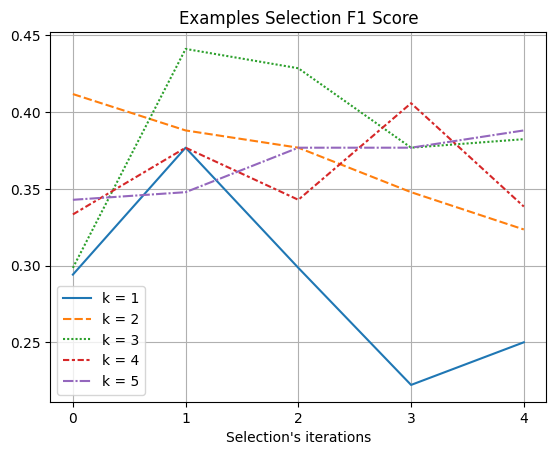

In [976]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils.constants import ANALYSIS_DIR

ax = sns.lineplot(pd.DataFrame(scores, index=[f'k = {k + 1}' for k in range(5)]).T)
plt.grid()
ax.xaxis.get_major_locator().set_params(integer=True)
ax.set_xlabel('Selection\'s iterations')
ax.set(title='Examples Selection F1 Score')
plt.savefig(ANALYSIS_DIR / 'images' / 'exampleSelectionPerStages.pdf', dpi=300)

0.35386788614845266

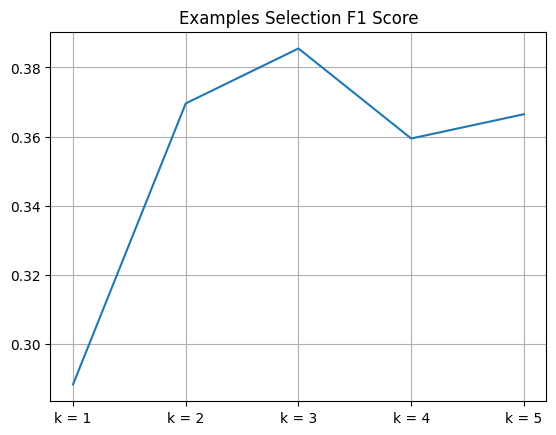

In [985]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils.constants import ANALYSIS_DIR

ax = sns.lineplot([np.mean(s) for s in scores])
plt.grid()
ax.xaxis.get_major_locator().set_params(integer=True)
ax.set_xticks(range(5))
ax.set_xticklabels([f'k = {k + 1}' for k in range(5)])
ax.set(title='Examples Selection F1 Score')
plt.savefig(ANALYSIS_DIR / 'images' / 'exampleSelectionPerK.pdf', dpi=300)

In [ ]:
top_examples

In [940]:
len(top_examples), len(possible_data)

(5, 127)

In [1013]:
possible_data

[{'text': 'El empresario está obligado a comunicar a la oficina pública de empleo, en el plazo de los diez días siguientes a su concertación y en los términos que reglamentariamente se determinen, el contenido de los contratos de trabajo que celebre o las prórrogas de los mismos, deban o no formalizarse por escrito.',
  'subject': 'empresario',
  'object': ['oficina pública de empleo'],
  'event': 'está obligado a comunicar',
  'complement': ['contratos de trabajo'],
  'subjectLabel': 'LegalAgent',
  'objectLabel': 'LegalEntity',
  'relationType': 'Duty'},
 {'text': 'El empresario entregará a la representación legal de los trabajadores una copia básica de todos los contratos que deban celebrarse por escrito, a excepción de los contratos de relación laboral especial de alta dirección sobre los que se establece el deber de notificación a la representación legal de los trabajadores.',
  'subject': 'empresario',
  'object': ['representación legal de los trabajadores'],
  'event': 'entregar

## 5-shot with selected examples

In [1012]:
top_examples

[{'text': 'Expirada la duración del contrato para la formación y el aprendizaje, el trabajador no podrá ser contratado bajo esta modalidad por la misma o distinta empresa, salvo que la formación inherente al nuevo contrato tenga por objeto la obtención de distinta cualificación profesional.',
  'subject': 'empresa',
  'object': ['trabajador'],
  'event': 'no podrá ser',
  'complement': ['contratado'],
  'subjectLabel': 'LegalAgent',
  'objectLabel': 'LegalAgent',
  'relationType': 'NoRight'},
 {'text': 'Aplicación de los límites de duración del contrato por obra o servicio determinados y al encadenamiento de contratos en las Administraciones Públicas.',
  'subject': 'Administraciones Públicas',
  'object': [],
  'event': None,
  'complement': [],
  'subjectLabel': 'LegalEntity',
  'relationType': 'Norelation'},
 {'text': 'La empresa conservará los registros a que se refiere este precepto durante cuatro años y permanecerán a disposición de las personas trabajadoras, de sus representante

In [948]:
eval_n = 5

few_sentences_select = [
    '\n\n'.join(s['text']
    for s in possible_data[i:i+eval_n])
    for i in range(0, len(possible_data), eval_n)
]

prompts = [(
    'The set of sentences in spanish to use in the'
    ' event extraction task is the following:\n'
    f'```\n{s}\n```') for s in few_sentences_select
]

In [947]:
len(prompts)

26

In [951]:
from utils.functions import get_completion

few_responses_select = []
examples_select = get_examples(top_examples)

for prompt in prompts:
    system = template % {
        'role_example': '\n\n'.join(examples_select['role']),
        'subject_type': '\n\n'.join(examples_select['subject-type']),
        'object_type': '\n\n'.join(examples_select['object-type']),
        'relation_type': '\n\n'.join(examples_select['relation-type']),
    }
    few_response_select = get_completion(system + '\n' + prompt)
    few_responses_select.append(few_response_select)

In [952]:
for i, x in enumerate(few_responses_select):
    try:
        json.loads(x)
    except:
        print(i)

In [953]:
responses_select_json = [jr for r in few_responses_select for jr in json.loads(r)]

In [954]:
len(possible_data), len(responses_select_json)

(127, 127)

In [955]:
from utils.metrics import match_score

match_score(possible_data, responses_select_json, 'exact').T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,79.0,31.0,0.0,2.0,15.0,0.63,0.71,0.67
Object,61.0,9.0,0.0,54.0,7.0,0.79,0.49,0.61
Event,82.0,19.0,0.0,0.0,26.0,0.65,0.81,0.72
Complement,44.0,7.0,0.0,83.0,3.0,0.81,0.33,0.47
Total,266.0,66.0,0.0,139.0,51.0,0.69,0.56,0.62


In [956]:
match_score(possible_data, responses_select_json, 'partial').T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,79.0,28.0,3.0,2.0,15.0,0.64,0.72,0.68
Object,61.0,7.0,2.0,54.0,7.0,0.81,0.50,0.62
Event,82.0,7.0,12.0,0.0,26.0,0.69,0.87,0.77
Complement,44.0,5.0,2.0,83.0,3.0,0.83,0.34,0.48
Total,266.0,47.0,19.0,139.0,51.0,0.72,0.58,0.65


In [1010]:
match_score(possible_data, responses_select_json, 'strict', ['subject', 'object', 'event']).T.round(2)

[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresarios', 'empresarios')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('dirección empresarial', 'dirección empresarial')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresas', 'empresas')] LegalAgent LegalEntity
[('empresa', 'empresa')] LegalAgent LegalEntity
17


,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,60.0,50.0,0.0,2.0,15.0,0.48,0.54,0.51
Object,56.0,14.0,0.0,54.0,7.0,0.73,0.45,0.56
Event,70.0,31.0,0.0,0.0,26.0,0.55,0.69,0.61
Total,186.0,95.0,0.0,56.0,48.0,0.57,0.55,0.56


In [1011]:
match_score(possible_data, responses_select_json, 'type', ['subject', 'object', 'event']).T.round(2)

[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'copia básica')] LegalAgent LegalConcept
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresarios', 'empresarios')] LegalAgent LegalEntity
[('empresario', 'empresario')] LegalAgent LegalEntity
[('empresario', 'denegación de la solicitud')] LegalAgent LegalConcept
[(None, 'trabajadores menores de dieciocho años')] False LegalAgent
[(None, 'acuerdos')] False LegalConcept
[('representantes de la Administración', 'representantes de la Administración, organizaciones sindicales, asociaciones empresariales')] LegalEntity LegalConcept
[('empresa', 'trabajador')] LegalAgent LegalAgent
[('empresario', 'empresario')] LegalAgent LegalEntity
[(None, 'sustituciones, revocaciones, dimisiones y extinciones de mandato')] False LegalConcept
[('empresario', 'empres

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,62.0,65.0,0.0,0.0,0.0,0.49,0.49,0.49
Object,58.0,73.0,0.0,0.0,0.0,0.44,0.44,0.44
Event,81.0,46.0,0.0,0.0,0.0,0.64,0.64,0.64
Total,201.0,184.0,0.0,0.0,0.0,0.52,0.52,0.52


In [959]:
from utils.metrics import match_relation_type_score

match_relation_type_score(possible_data, responses_select_json)

90 13 127 13


(0.4147465437788018, 0.8737864077669902, 0.5625)

In [960]:
from utils.metrics import confusion_matrix

confusion_matrix(possible_data, responses_select_json, 'relationType')

,right,privilege,norelation,duty,noright,none
right,23,7,0,2,4,0
privilege,1,1,0,2,0,0
norelation,0,0,13,12,9,0
duty,0,0,0,47,0,0
noright,0,0,0,0,6,0
none,0,0,0,0,0,0


In [961]:
from utils.metrics import compute_average_similarity_score

print(f'''
Subject - {compute_average_similarity_score(possible_data, responses_select_json, 'subject')}
Object - {compute_average_similarity_score(possible_data, responses_select_json, 'object')}
Trigger - {compute_average_similarity_score(possible_data, responses_select_json, 'event')}
Complement - {compute_average_similarity_score(possible_data, responses_select_json, 'complement')}
''')



Subject - 0.6755119336361053
Object - 0.4832282441264037
Trigger - 0.7324603419880342
Complement - 0.3393445021137477



## 3-shot with selected examples

In [986]:
examples_select_3 = top_examples[:3]
true_data_select_3 = possible_data + top_examples[3:]

In [987]:
eval_n = 5

few_sentences_select_3 = [
    '\n\n'.join(s['text']
    for s in true_data_select_3[i: i+eval_n])
    for i in range(0, len(true_data_select_3), eval_n)
]

prompts_3 = [(
    'The set of sentences in spanish to use in the'
    ' event extraction task is the following:\n'
    f'```\n{s}\n```') for s in few_sentences_select_3
]

In [989]:
len(prompts_3)

26

In [990]:
from utils.functions import get_completion

few_responses_select_3 = []
examples_select_3 = get_examples(examples_select_3)

for prompt in prompts_3:
    system = template % {
        'role_example': '\n\n'.join(examples_select_3['role']),
        'subject_type': '\n\n'.join(examples_select_3['subject-type']),
        'object_type': '\n\n'.join(examples_select_3['object-type']),
        'relation_type': '\n\n'.join(examples_select_3['relation-type']),
    }
    few_response_select_3 = get_completion(system + '\n' + prompt)
    few_responses_select_3.append(few_response_select_3)

In [991]:
for i, x in enumerate(few_responses_select_3):
    try:
        json.loads(x)
    except:
        print(i)

In [992]:
responses_select_json_3 = [jr for r in few_responses_select_3 for jr in json.loads(r)]

In [993]:
len(true_data_select_3), len(responses_select_json_3)

(129, 129)

In [994]:
from utils.metrics import match_score

match_score(true_data_select_3, responses_select_json_3, 'exact').T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,76.0,34.0,0.0,0.0,19.0,0.59,0.69,0.64
Object,64.0,13.0,0.0,48.0,12.0,0.72,0.51,0.60
Event,81.0,20.0,0.0,0.0,28.0,0.63,0.80,0.70
Complement,39.0,15.0,0.0,75.0,21.0,0.52,0.30,0.38
Total,260.0,82.0,0.0,123.0,80.0,0.62,0.56,0.59


In [995]:
match_score(true_data_select_3, responses_select_json_3, 'partial').T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,76.0,31.0,3.0,0.0,19.0,0.60,0.70,0.65
Object,64.0,10.0,3.0,48.0,12.0,0.74,0.52,0.61
Event,81.0,7.0,13.0,0.0,28.0,0.68,0.87,0.76
Complement,39.0,12.0,3.0,75.0,21.0,0.54,0.31,0.40
Total,260.0,60.0,22.0,123.0,80.0,0.64,0.58,0.61


In [996]:
match_score(true_data_select_3, responses_select_json_3, 'strict', ['subject', 'object', 'event']).T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,59.0,51.0,0.0,0.0,19.0,0.46,0.54,0.49
Object,58.0,19.0,0.0,48.0,12.0,0.65,0.46,0.54
Event,68.0,33.0,0.0,0.0,28.0,0.53,0.67,0.59
Total,185.0,103.0,0.0,48.0,59.0,0.53,0.55,0.54


In [997]:
match_score(true_data_select_3, responses_select_json_3, 'type', ['subject', 'object', 'event']).T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,61.0,68.0,0.0,0.0,0.0,0.47,0.47,0.47
Object,61.0,76.0,0.0,0.0,0.0,0.45,0.45,0.45
Event,80.0,49.0,0.0,0.0,0.0,0.62,0.62,0.62
Total,202.0,193.0,0.0,0.0,0.0,0.51,0.51,0.51


In [ ]:
from utils.metrics import match_relation_type_score

match_relation_type_score(true_data_select_3, responses_select_json_3)

In [ ]:
from utils.metrics import confusion_matrix

confusion_matrix(true_data_select_3, responses_select_json_3, 'relationType')

In [ ]:
from utils.metrics import compute_average_similarity_score

print(f'''
Subject - {compute_average_similarity_score(true_data_select_3, responses_select_json_3, 'subject')}
Object - {compute_average_similarity_score(true_data_select_3, responses_select_json_3, 'object')}
Trigger - {compute_average_similarity_score(true_data_select_3, responses_select_json_3, 'event')}
Complement - {compute_average_similarity_score(true_data_select_3, responses_select_json_3, 'complement')}
''')


# Few-shot learning (more quality demonstrations)

In [866]:
examples_data, validation_data = example_validation_split(all_sentences_data, [1, 1, 0, 1, 1], 'relationType')
examples_data

[{'text': 'El Fondo de Garantía Salarial prestará a la institución de garantía competente la colaboración que le sea requerida en relación con su intervención en el procedimiento y con el reembolso de las cantidades abonadas a los trabajadores.',
  'subject': 'Fondo de Garantía Salarial',
  'object': ['institución'],
  'event': 'prestará',
  'complement': ['colaboración'],
  'subjectLabel': 'LegalEntity',
  'objectLabel': 'LegalEntity',
  'relationType': 'Duty'},
 {'text': 'Los trabajadores menores de dieciocho años  no podrán realizar más de ocho horas diarias de trabajo efectivo, incluyendo, en su caso, el tiempo dedicado a la formación y, si trabajasen para varios empleadores, las horas realizadas con cada uno de ellos.',
  'subject': 'trabajadores menores de dieciocho años',
  'object': [],
  'event': 'no podrán realizar',
  'complement': ['trabajo efectivo'],
  'subjectLabel': 'LegalAgent',
  'relationType': 'NoRight'},
 {'text': 'El Gobierno, previas las consultas que considere o

In [867]:
from utils.functions import get_examples

eval_n = 5

examples = get_examples(examples_data)
few_evaluation_data_2 = validation_data.copy()
few_sentences_bins = ['\n\n'.join(s['text'] for s in few_evaluation_data_2[i: i+eval_n]) for i in range(0, len(few_evaluation_data_2), eval_n)]

In [868]:
from pprint import pprint
pprint(examples)

{'object-type': ['Example 1:\n'
                 'Input:\n'
                 '    * sentence: El Fondo de Garantía Salarial prestará a la '
                 'institución de garantía competente la colaboración que le '
                 'sea requerida en relación con su intervención en el '
                 'procedimiento y con el reembolso de las cantidades abonadas '
                 'a los trabajadores.\n'
                 "    * object: ['institución']\n"
                 'Output: LegalEntity\n',
                 'Example 2:\n'
                 'Input:\n'
                 '    * sentence: Los trabajadores menores de dieciocho años  '
                 'no podrán realizar más de ocho horas diarias de trabajo '
                 'efectivo, incluyendo, en su caso, el tiempo dedicado a la '
                 'formación y, si trabajasen para varios empleadores, las '
                 'horas realizadas con cada uno de ellos.\n'
                 '    * object: []\n'
                 'Output: N

In [869]:
system = f'''
You are a tool that will compute the results from an event extraction task from spanish legal text following this guidelines:

Given a large set of sentences in spanish from the legal domain, written between triple backticks, your objective is to extract the roles, role types and relation type from the text written in Spanish following the next steps:
1. Identify each sentence in the corpus separated for new lines.
2. In each sentence detect a subject entity, object entities, an event trigger and complement entities following the next definitions. The examples are expressed between triple dashes:
    * subject: Entity who performs the action.
    * event trigger: Action
    * object: Receiver of the action. There can be more than one object in the sentence.
    * complement: Item which is handled in the relation. There can be more than one complement in the sentence.

---
    {examples["role"][0]}

    {examples["role"][1]}

    {examples["role"][2]}

    {examples["role"][3]}
---

3. Classify each subject in one of the following labels:
    * LegalAgent: Natural person
    * LegalEntity: Not natural person nor individual. Normally a corporation or an enterprise
    * LegalConcept: Not natural person nor corporation.

---
    {examples["subject-type"][0]}

    {examples["subject-type"][1]}

    {examples["subject-type"][2]}

    {examples["subject-type"][3]}
---

4. Classify each object entity in one of the labels of previous step. If no object is present in the sentence, just leave it as null.

---
    {examples["object-type"][0]}

    {examples["object-type"][1]}

    {examples["object-type"][2]}

    {examples["object-type"][3]}
---

5. Classify the relation in one of the following classes:
    * Right
    * Duty
    * NoRight
    * Privilege
Right and NoRight are opposites and Duty and Privilege are opposite as well. If there is a sentence that does not contains a relation, classify it as Norelation.

---
    {examples["relation-type"][0]}

    {examples["relation-type"][1]}

    {examples["relation-type"][2]}

    {examples["relation-type"][3]}
---

6. The output of the task should be a list of jsons where each json contains the following keys:
    * text: the sentence
    * subject: the subject entity
    * object: the list of object entities or empty list
    * event: the event trigger
    * complement: the list of complement entities or empty list
    * subjectLabel: the classification of the subject entity in step 3
    * objectLabel: the classification of the object entity in step 4. All objects entities have the same classification
    * relationType: the classification of the relation in step 5
'''

In [870]:
prompts = [f'''
The set of sentences in spanish to use in the event extraction task is the following:

```
{s}
```
''' for s in few_sentences_bins]

In [872]:
from utils.functions import get_completion

few_responses_2 = []
for prompt in prompts:
    few_response_2 = get_completion(system + '\n' + prompt)
    few_responses_2.append(few_response_2)

In [873]:
for i, x in enumerate(few_responses_2):
    try:
        json.loads(x)
    except:
        print(i)

In [608]:
b = few_sentences_bins[21].split('\n\n')

In [609]:
a_s = "\n\n".join(b[:3])
a = get_completion(
    system \
    + f'\nThe set of sentences in spanish to use in the event extraction task is the following:\n\n```{a_s}```'
)
c_s = "\n\n".join(b[3:])
c = get_completion(
    system \
    + f'\nThe set of sentences in spanish to use in the event extraction task is the following:\n\n```{c_s}```'
)

In [610]:
d = json.dumps(json.loads(a) + json.loads(c))

In [612]:
few_responses_2[21] = d

In [874]:
responses_json = [jr for r in few_responses_2 for jr in json.loads(r)]

In [875]:
responses_json

[{'text': 'El empresario está obligado a comunicar a la oficina pública de empleo, en el plazo de los diez días siguientes a su concertación y en los términos que reglamentariamente se determinen, el contenido de los contratos de trabajo que celebre o las prórrogas de los mismos, deban o no formalizarse por escrito.',
  'subject': 'empresario',
  'object': ['oficina pública de empleo'],
  'event': 'comunicar',
  'complement': ['contenido de los contratos de trabajo'],
  'subjectLabel': 'LegalAgent',
  'objectLabel': 'LegalEntity',
  'relationType': 'Duty'},
 {'text': 'El empresario entregará a la representación legal de los trabajadores una copia básica de todos los contratos que deban celebrarse por escrito, a excepción de los contratos de relación laboral especial de alta dirección sobre los que se establece el deber de notificación a la representación legal de los trabajadores.',
  'subject': 'empresario',
  'object': ['representación legal de los trabajadores'],
  'event': 'entrega

In [876]:
len(few_evaluation_data_2), len(responses_json)

(128, 128)

In [879]:
from utils.metrics import match_score

match_score(few_evaluation_data_2, responses_json, 'exact').T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,57.0,52.0,0.0,0.0,19.0,0.45,0.52,0.48
Object,57.0,22.0,0.0,40.0,17.0,0.59,0.48,0.53
Event,76.0,23.0,0.0,0.0,29.0,0.59,0.77,0.67
Complement,37.0,39.0,0.0,40.0,59.0,0.27,0.32,0.29
Total,227.0,136.0,0.0,80.0,124.0,0.47,0.51,0.49


In [880]:
match_score(few_evaluation_data_2, responses_json, 'partial').T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,57.0,39.0,13.0,0.0,19.0,0.50,0.58,0.54
Object,57.0,18.0,4.0,40.0,17.0,0.61,0.50,0.55
Event,76.0,12.0,11.0,0.0,29.0,0.64,0.82,0.72
Complement,37.0,33.0,6.0,40.0,59.0,0.30,0.34,0.32
Total,227.0,102.0,34.0,80.0,124.0,0.50,0.55,0.52


In [881]:
match_score(few_evaluation_data_2, responses_json, 'strict', ['subject', 'object', 'event']).T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,53.0,56.0,0.0,0.0,19.0,0.41,0.49,0.45
Object,54.0,25.0,0.0,40.0,17.0,0.56,0.45,0.50
Event,59.0,40.0,0.0,0.0,29.0,0.46,0.60,0.52
Total,166.0,121.0,0.0,40.0,65.0,0.47,0.51,0.49


In [882]:
match_score(few_evaluation_data_2, responses_json, 'type', ['subject', 'object', 'event']).T.round(2)

,COR,INC,PAR,MIS,SPU,Precision,Recall,F1 Score
Subject,64.0,64.0,0.0,0.0,0.0,0.50,0.50,0.50
Object,57.0,79.0,0.0,0.0,0.0,0.42,0.42,0.42
Event,67.0,61.0,0.0,0.0,0.0,0.52,0.52,0.52
Total,188.0,204.0,0.0,0.0,0.0,0.48,0.48,0.48


In [673]:
from utils.metrics import match_relation_type_score

match_relation_type_score(few_evaluation_data_2, responses_json)

110 27 141 30


(0.43824701195219123, 0.7857142857142857, 0.5626598465473146)

In [708]:
from utils.metrics import confusion_matrix

confusion_matrix(few_evaluation_data_2, responses_json, 'relationType')

,right,norelation,privilege,duty,noright
right,25,1,7,4,2
norelation,6,27,0,2,4
privilege,1,0,1,1,0
duty,1,2,0,46,1
noright,0,1,0,0,9


In [669]:
from utils.metrics import compute_average_similarity_score

print(f'''
Subject - {compute_average_similarity_score(few_evaluation_data_2, responses_json, 'subject')}
Object - {compute_average_similarity_score(few_evaluation_data_2, responses_json, 'object')}
Trigger - {compute_average_similarity_score(few_evaluation_data_2, responses_json, 'event')}
Complement - {compute_average_similarity_score(few_evaluation_data_2, responses_json, 'complement')}
''')



Subject - 0.6830613359888189
Object - 0.5296849644574839
Trigger - 0.6710719847213368
Complement - 0.22892600204259192

